## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import tensorflow as tf
import itertools
# 不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 60% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x) # 隨機在一次update中，忽略了20%的neurons間的connection
            x = BatchNormalization()(x) # 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x) # 隨機在一次update中，忽略了25%的neurons間的connection
            x = BatchNormalization()(x) # 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3   # 學習率
EPOCHS = 30 # 訓練30週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = [2, 16, 32, 128, 256]# 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 #動量
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    for batchsize in BATCH_SIZE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, # 訓練資料。
                  epochs=EPOCHS,     # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
                  batch_size=batchsize,  # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
                  validation_data=(x_test, y_test),  # 驗證資料。
                  shuffle=True)   # 每次epochs後，將訓練集打亂順序。

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-accuracy': train_acc,
                                 'valid-accuracy': valid_acc}


Experiment with Regulizer = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 22s 449us/step - loss: 7.4434 - accuracy: 0.2567 - val_loss: 3.5691 - val_accuracy: 0.2049
Epoch 2/30
50000/50000 [==============================] - 22s 431us/step - loss: 2.6037 - accuracy: 0.2456 - val_loss: 2.1958 - val_accuracy: 0.2819
Epoch 3/30
50000/50000 [==============================] - 22s 432us/step - loss: 2.1594 - accuracy: 0.2418 - val_loss: 2.1524 - val_accuracy: 0.2198
Epoch 4/30
50000/50000 [==============================] - 22s 431us/step - loss: 2.1028 - accuracy: 0.2404 - val_loss: 2.0512 - val_accuracy: 0.2808
Epoch 5/30
50000/50000 [==============================] - 22s 432us/step - loss: 2.1683 - accuracy: 0.1976 - val_loss: 2.1909 - val_accuracy: 0.1911
Epoch 6/30
50000/50000 [==============================] - 22s 433us/step - loss: 2.2495 - accuracy: 0.1858 - val_loss: 2.1807 - val_accuracy: 0.1953
Epoch 7/30
50000/50000 [==============================] 

Epoch 13/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.9628 - accuracy: 0.3052 - val_loss: 2.0484 - val_accuracy: 0.2723
Epoch 14/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.9583 - accuracy: 0.3057 - val_loss: 1.9684 - val_accuracy: 0.2796
Epoch 15/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.9765 - accuracy: 0.2984 - val_loss: 1.9291 - val_accuracy: 0.3310
Epoch 16/30
50000/50000 [==============================] - 11s 222us/step - loss: 1.9511 - accuracy: 0.3109 - val_loss: 1.8933 - val_accuracy: 0.3343
Epoch 17/30
50000/50000 [==============================] - 11s 223us/step - loss: 2.0031 - accuracy: 0.2920 - val_loss: 1.9579 - val_accuracy: 0.3193
Epoch 18/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.9817 - accuracy: 0.2986 - val_loss: 1.9728 - val_accuracy: 0.2776
Epoch 19/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.9704 - accuracy:

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 165s 3ms/step - loss: 3.9946 - accuracy: 0.1405 - val_loss: 4.0164 - val_accuracy: 0.1876
Epoch 2/30
50000/50000 [==============================] - 164s 3ms/step - loss: 4.1039 - accuracy: 0.1571 - val_loss: 4.0764 - val_accuracy: 0.2032
Epoch 3/30
50000/50000 [==============================] - 162s 3ms/step - loss: 4.0553 - accuracy: 0.1548 - val_loss: 4.0305 - val_accuracy: 0.1995
Epoch 4/30
50000/50000 [==============================] - 163s 3ms/step - loss: 6.1825 - accuracy: 0.1569 - val_loss: 8.3739 - val_accuracy: 0.2087
Epoch 5/30
50000/50000 [==============================] - 163s 3ms/step - loss: 7.9571 - accuracy: 0.1580 - val_loss: 7.7096 - val_accuracy: 0.1856
Epoch 6/30
50000/50000 [==============================] - 162s 3ms/step - loss: 7.1806 - accuracy: 0.1553 - val_loss: 7.1206 - val_accuracy: 0.1976
Epoch 7/30
50000/50000 [==============================] - 162s

Epoch 13/30
50000/50000 [==============================] - 21s 430us/step - loss: 2.0371 - accuracy: 0.2982 - val_loss: 1.9407 - val_accuracy: 0.3597
Epoch 14/30
50000/50000 [==============================] - 22s 431us/step - loss: 2.0190 - accuracy: 0.3112 - val_loss: 1.9195 - val_accuracy: 0.3590
Epoch 15/30
50000/50000 [==============================] - 22s 431us/step - loss: 2.0098 - accuracy: 0.3127 - val_loss: 1.9234 - val_accuracy: 0.3549
Epoch 16/30
50000/50000 [==============================] - 22s 431us/step - loss: 2.0231 - accuracy: 0.3073 - val_loss: 1.9271 - val_accuracy: 0.3678
Epoch 17/30
50000/50000 [==============================] - 22s 431us/step - loss: 2.0323 - accuracy: 0.3019 - val_loss: 1.9466 - val_accuracy: 0.3491
Epoch 18/30
50000/50000 [==============================] - 21s 429us/step - loss: 2.0089 - accuracy: 0.3090 - val_loss: 1.9579 - val_accuracy: 0.3534
Epoch 19/30
50000/50000 [==============================] - 21s 427us/step - loss: 2.0091 - accuracy:

50000/50000 [==============================] - 11s 223us/step - loss: 1.7833 - accuracy: 0.4021 - val_loss: 1.6837 - val_accuracy: 0.4376
Epoch 26/30
50000/50000 [==============================] - 11s 222us/step - loss: 1.7740 - accuracy: 0.4051 - val_loss: 1.7009 - val_accuracy: 0.4317
Epoch 27/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.7674 - accuracy: 0.4056 - val_loss: 1.6819 - val_accuracy: 0.4445
Epoch 28/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.7615 - accuracy: 0.4083 - val_loss: 1.6916 - val_accuracy: 0.4447
Epoch 29/30
50000/50000 [==============================] - 11s 223us/step - loss: 1.7474 - accuracy: 0.4133 - val_loss: 1.6753 - val_accuracy: 0.4486
Epoch 30/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.7428 - accuracy: 0.4133 - val_loss: 1.6488 - val_accuracy: 0.4492
Experiment with Regulizer = 0.000100
Model: "model_1"
__________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 71us/step - loss: 2.4134 - accuracy: 0.2477 - val_loss: 1.9703 - val_accuracy: 0.3445
Epoch 2/30
50000/50000 [==============================] - 3s 56us/step - loss: 2.0593 - accuracy: 0.3244 - val_loss: 1.8679 - val_accuracy: 0.3880
Epoch 3/30
50000/50000 [==============================] - 3s 56us/step - loss: 1.9317 - accuracy: 0.3633 - val_loss: 1.7751 - val_accuracy: 0.4103
Epoch 4/30
50000/50000 [==============================] - 3s 56us/step - loss: 1.8678 - accuracy: 0.3858 - val_loss: 1.7037 - val_accuracy: 0.4443
Epoch 5/30
50000/50000 [==============================] - 3s 56us/step - loss: 1.8175 - accuracy: 0.3996 - val_loss: 1.7035 - val_accuracy: 0.4347
Epoch 6/30
50000/50000 [==============================] - 3s 56us/step - loss: 1.7701 - accuracy: 0.4167 - val_loss: 1.6732 - val_accuracy: 0.4515
Epoch 7/30
50000/50000 [==============================] - 3s 56us/st

50000/50000 [==============================] - 21s 428us/step - loss: 1.9112 - accuracy: 0.3039 - val_loss: 1.8175 - val_accuracy: 0.3597
Epoch 26/30
50000/50000 [==============================] - 21s 429us/step - loss: 1.8941 - accuracy: 0.3122 - val_loss: 1.7880 - val_accuracy: 0.3670
Epoch 27/30
50000/50000 [==============================] - 21s 427us/step - loss: 1.8885 - accuracy: 0.3150 - val_loss: 1.7751 - val_accuracy: 0.3799
Epoch 28/30
50000/50000 [==============================] - 21s 428us/step - loss: 1.8857 - accuracy: 0.3175 - val_loss: 1.8334 - val_accuracy: 0.3343
Epoch 29/30
50000/50000 [==============================] - 21s 424us/step - loss: 1.8873 - accuracy: 0.3134 - val_loss: 1.8791 - val_accuracy: 0.3177
Epoch 30/30
50000/50000 [==============================] - 21s 426us/step - loss: 1.8775 - accuracy: 0.3190 - val_loss: 1.7710 - val_accuracy: 0.3884
Experiment with Regulizer = 0.000000
Model: "model_1"
__________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s 98us/step - loss: 2.1469 - accuracy: 0.2665 - val_loss: 1.7586 - val_accuracy: 0.3601
Epoch 2/30
50000/50000 [==============================] - 4s 84us/step - loss: 1.8304 - accuracy: 0.3478 - val_loss: 1.6839 - val_accuracy: 0.3909
Epoch 3/30
50000/50000 [==============================] - 4s 84us/step - loss: 1.7429 - accuracy: 0.3733 - val_loss: 1.5951 - val_accuracy: 0.4241
Epoch 4/30
50000/50000 [==============================] - 4s 83us/step - loss: 1.6881 - accuracy: 0.3919 - val_loss: 1.6075 - val_accuracy: 0.4183
Epoch 5/30
50000/50000 [==============================] - 4s 84us/step - loss: 1.6528 - accuracy: 0.4065 - val_loss: 1.5464 - val_accuracy: 0.4438
Epoch 6/30
50000/50000 [==============================] - 4s 83us/step - loss: 1.6401 - accuracy: 0.4113 - val_loss: 1.5443 - val_accuracy: 0.4394
Epoch 7/30
50000/50000 [==============================] - 4s 85us/st

50000/50000 [==============================] - 162s 3ms/step - loss: 2.2517 - accuracy: 0.1566 - val_loss: 2.2888 - val_accuracy: 0.2051
Epoch 26/30
50000/50000 [==============================] - 162s 3ms/step - loss: 2.2503 - accuracy: 0.1570 - val_loss: 2.3330 - val_accuracy: 0.2219
Epoch 27/30
50000/50000 [==============================] - 163s 3ms/step - loss: 2.2505 - accuracy: 0.1548 - val_loss: 2.4052 - val_accuracy: 0.1963
Epoch 28/30
50000/50000 [==============================] - 162s 3ms/step - loss: 2.2494 - accuracy: 0.1570 - val_loss: 2.4585 - val_accuracy: 0.1930
Epoch 29/30
50000/50000 [==============================] - 162s 3ms/step - loss: 2.2468 - accuracy: 0.1559 - val_loss: 2.5635 - val_accuracy: 0.1950
Epoch 30/30
50000/50000 [==============================] - 163s 3ms/step - loss: 2.2490 - accuracy: 0.1560 - val_loss: 2.2906 - val_accuracy: 0.2294
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 12s 240us/step - loss: 2.0205 - accuracy: 0.2821 - val_loss: 1.7495 - val_accuracy: 0.3684
Epoch 2/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.8392 - accuracy: 0.3357 - val_loss: 1.7177 - val_accuracy: 0.3901
Epoch 3/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.8133 - accuracy: 0.3434 - val_loss: 1.7055 - val_accuracy: 0.3830
Epoch 4/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.8232 - accuracy: 0.3407 - val_loss: 1.7217 - val_accuracy: 0.3817
Epoch 5/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.8250 - accuracy: 0.3419 - val_loss: 1.7702 - val_accuracy: 0.3676
Epoch 6/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.8213 - accuracy: 0.3414 - val_loss: 1.6935 - val_accuracy: 0.3904
Epoch 7/30
50000/50000 [==============================] 

50000/50000 [==============================] - 3s 57us/step - loss: 1.3934 - accuracy: 0.5019 - val_loss: 1.3828 - val_accuracy: 0.5036
Epoch 25/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.3837 - accuracy: 0.5009 - val_loss: 1.4063 - val_accuracy: 0.4985
Epoch 26/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.3673 - accuracy: 0.5086 - val_loss: 1.4153 - val_accuracy: 0.4941
Epoch 27/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.3733 - accuracy: 0.5049 - val_loss: 1.4077 - val_accuracy: 0.4938
Epoch 28/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.3662 - accuracy: 0.5092 - val_loss: 1.3861 - val_accuracy: 0.4993
Epoch 29/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.3558 - accuracy: 0.5124 - val_loss: 1.3734 - val_accuracy: 0.5113
Epoch 30/30
50000/50000 [==============================] - 3s 57us/step - loss: 1.3539 - accuracy: 0.5124 - val_loss: 1.3922

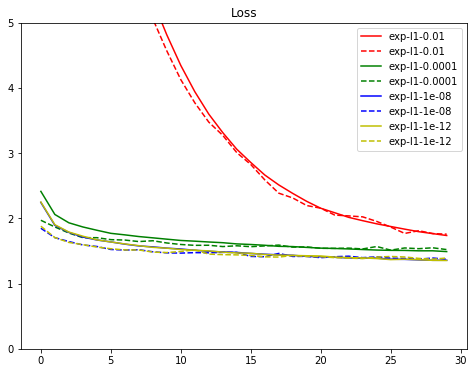

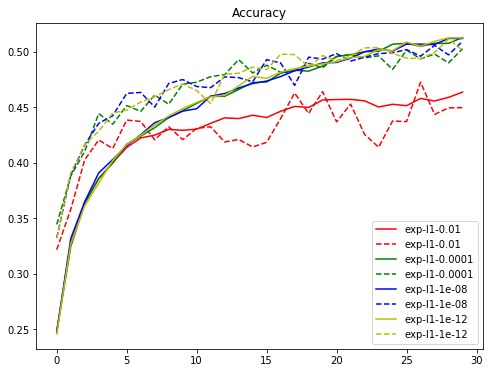

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()